In [1515]:
import pandas as pd
df = pd.read_csv("final table.csv", sep=';', encoding='windows-1251')

In [1304]:
df.dtypes

shopId           int64
skuId            int64
sales           object
salesRub        object
date            object
promoId         object
startDate       object
finishDate      object
price           object
discont         object
priceAkcia      object
typePromo       object
statusPromo    float64
dtype: object

In [1305]:
df.shape

(1048575, 13)

In [1516]:
df['count_skuId'] = 1
df['count_promo'] = df.promoId.isna().map({True:0, False: 1})
df.head()

,shopId,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,priceAkcia,typePromo,statusPromo,count_skuId,count_promo
0,174,47336,"0,39","37,01",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,174,101235,"0,745","63,25",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,172,25880,"0,925","92,41",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,172,4715,3,"109,5",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,172,4342,"1,5",78,10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [1517]:
gr = df.groupby(df.skuId)
t = pd.DataFrame(gr['count_skuId'].sum())
q = pd.DataFrame(gr['count_promo'].sum())

In [1518]:
display(t.sort_values(by='count_skuId', ascending=False))
display(q.sort_values(by='count_promo', ascending=False))

,count_skuId
skuId,
4342,71280
51980,62886
47336,45305
152927,31875
25880,30851
...,...
10000358,13
193140,12
10000356,10


,count_promo
skuId,
125296,1618
3553,1567
187925,1446
152927,1145
151207,1021
...,...
191927,0
118456,0
118454,0


In [1523]:
m = t.reset_index()
m[m.skuId == 151207]

,skuId,count_skuId
97,151207,10789


Выбираем skuId 3553,skuId 152927,skuId 10789, т.к. у него больше всех count_promo и count. 03553;Вода Иркутская минер газир 2л пэт;01020101 Газированная

In [1313]:
del df['count_skuId']
del df['count_promo']

In [1544]:
def preprocess_df(df):
    skuId = 3553
    df = df[df.skuId == skuId]
    
    df_19_20 = pd.read_csv("skuid 03553 in 19-20.csv", sep=';', encoding='windows-1251')
    df_19_20.rename(columns={'п»їshopId':'shopId'}, inplace=True)
    df = pd.concat([df, df_19_20], axis=0)
    
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['date'] = pd.to_datetime(df['date'])
    df['finishDate'] = pd.to_datetime(df['finishDate'])
    
    df['sales'] = df['sales'].astype(int)
    df['salesRub'] = df['salesRub'].str.replace(',', '.').astype(float)
    
    cond = (df.promoId.notna())
    df[cond]['price'] = df[cond]['price'].str.replace(',', '.').astype(float)
    df['price'] = df[cond]['price'].str.replace(',', '.').astype(float)

    del df['statusPromo']
    del df['typePromo']
    del df['priceAkcia']
    df = df.reset_index(drop=True)
    return df

/home/max/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Кол-во продаж в день')

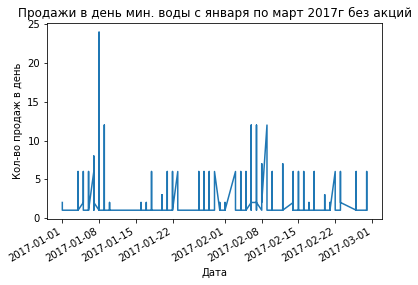

In [1314]:
cond = (df.promoId.isna())
t = df[cond]
t['date'] = pd.to_datetime(t['date'])
t = t[(t.date < '2017-03-01')]
t.set_index(['date'], inplace=True)
t['sales'] = pd.to_numeric(t['sales'])
ax = t['sales'].plot(title='Продажи в день мин. воды с января по март 2017г без акций')
ax.set_xlabel("Дата")
ax.set_ylabel("Кол-во продаж в день")

Text(0, 0.5, 'Кол-во продаж в день')

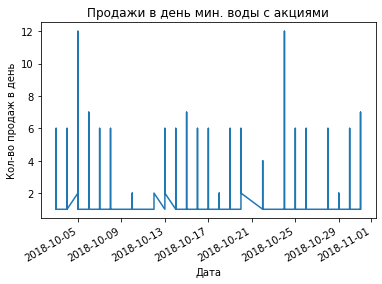

In [1315]:
cond = (df.skuId == skuId)# & (df.promoId.notna())
t = df[cond]
t['date'] = pd.to_datetime(t['date'])
t = t[('2018-10-01' < t.date) & (t.date < '2018-11-01')]
t.set_index(['date'], inplace=True)
t['sales'] = pd.to_numeric(t['sales'])
ax = t['sales'].plot(title='Продажи в день мин. воды с акциями')
ax.set_xlabel("Дата")
ax.set_ylabel("Кол-во продаж в день")

# Feature engeniring

In [1545]:
def feature_engeniring(df):
    df['price'] = df['salesRub'] / df['sales']
    
    # номер месяца
    df['block_num'] = df.date.apply(lambda row: row.month + (row.year - 2017) * 12)
    
    # процент изменения цены в акции
    df['percentage_price_change'] = 0.
    df.reset_index(drop=True, inplace=True)
    cond = (df.promoId.notna())
    df.loc[cond, 'percentage_price_change'] = df.discont * 100 / df.price
    df = df.groupby(['block_num', 'shopId'])['percentage_price_change'].max().reset_index().merge(df.drop(['percentage_price_change'], axis=1), on=['block_num', 'shopId'], how='inner')
    
    # кол-во акций в месяце
    q = df.groupby(['block_num', 'shopId'])['startDate'].nunique().reset_index()
    q.rename(columns={'startDate': 'promo_num_month'}, inplace=True)
    df = pd.merge(df, q, how = 'inner', on=['block_num', 'shopId'])
    
    # кол-во дней в месяце с акцией
    from calendar import monthrange
    cond = (df.promoId.notna())
    t = df[cond].apply(lambda row: (row.finishDate  - row.startDate).days if row.finishDate.month == row.startDate.month else (monthrange(row.startDate.year, row.startDate.month)[1] - row.startDate.day), axis=1)
    df = df.join(t.rename("num_of_promo_days_month").to_frame())
    df['num_of_promo_days_month'] = df['num_of_promo_days_month'].fillna(0)
    df = df.groupby(['block_num', 'shopId'])['num_of_promo_days_month'].max().reset_index().merge(df.drop(['num_of_promo_days_month'], axis=1), on=['block_num', 'shopId'], how='inner')
    
    return df

номер месяца

In [1321]:
df['date'] = pd.to_datetime(df.date)
df['block_num'] = df.date.apply(lambda row: row.month + (row.year - 2017) * 12)
#sorted(df['block_num'].unique())

процент изменения цены в акции

In [1322]:
cond = (df.promoId.notna())
df['discont'] = df[cond]['discont'].str.replace(',', '.').astype(float)
df['price'] = df[cond]['price'].str.replace(',', '.').astype(float)

In [1323]:
df['percentage_price_change'] = 0.

In [1324]:
df

,shopId,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,block_num,percentage_price_change
55,172,3553,1,"39,9",2018-05-04,NaN,NaN,NaN,56.9,29.88,17,0.0
62,173,3553,1,"50,9",2018-05-04,NaN,NaN,NaN,56.9,29.88,17,0.0
141,170,3553,1,"37,9",2018-02-06,NaN,NaN,NaN,56.9,29.88,14,0.0
146,174,3553,1,"53,5",2018-08-12,NaN,NaN,NaN,NaN,NaN,20,0.0
183,172,3553,6,"233,4",2017-03-10,NaN,NaN,NaN,56.9,21.09,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18478,173,3553,1,"39,9",2019-01-06,SLAT-170000932,2018-12-26,2019-01-15,56.9,29.88,25,0.0
18479,170,3553,2,"79,8",2019-01-06,SLAT-170000628,2018-12-26,2019-01-15,56.9,29.88,25,0.0
18480,170,3553,2,"79,8",2019-01-06,SLAT-170000932,2018-12-26,2019-01-15,56.9,29.88,25,0.0
18481,174,3553,1,"39,9",2019-01-06,SLAT-170000628,2018-12-26,2019-01-15,56.9,29.88,25,0.0


In [1325]:
df.reset_index(drop=True, inplace=True)
cond = (df.promoId.notna())
df.loc[cond, 'percentage_price_change'] = df.discont * 100 / df.price

In [1326]:
df = df.groupby(['block_num', 'shopId'])['percentage_price_change'].max().reset_index().merge(df.drop(['percentage_price_change'], axis=1), on=['block_num', 'shopId'], how='inner')

In [1327]:
cond = (df.promoId.notna())
df.loc[cond]

,block_num,shopId,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont
25597,22,170,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,17.10.2018,30.10.2018,56.9,29.88
25599,22,170,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,17.10.2018,30.10.2018,56.9,29.88
25600,22,170,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,17.10.2018,30.10.2018,56.9,29.88
25601,22,170,52.513181,3553,2,"79,8",2018-10-25,SLAT-170000409,17.10.2018,30.10.2018,56.9,29.88
25602,22,170,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,17.10.2018,30.10.2018,56.9,29.88
...,...,...,...,...,...,...,...,...,...,...,...,...
47878,39,174,39.857143,3553,7,"304,5",2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32
47879,39,174,39.857143,3553,1,"43,5",2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32
47888,39,174,39.857143,3553,2,87,2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32
47898,39,174,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32


кол-во акций в месяце

In [1328]:
q = df.groupby(['block_num', 'shopId'])['startDate'].nunique().reset_index()
q.rename(columns={'startDate': 'promo_num_month'}, inplace=True)

In [1329]:
q

,block_num,shopId,promo_num_month
0,1,170,0
1,1,172,0
2,1,173,0
3,1,174,0
4,2,170,0
...,...,...,...
151,38,174,1
152,39,170,1
153,39,172,1
154,39,173,1


In [1330]:
df = pd.merge(df, q, how = 'inner', on=['block_num', 'shopId'])

In [1331]:
df.shape

(47902, 13)

кол-во дней в месяце с акцией

In [1332]:
from calendar import monthrange

In [1334]:
cond = (df.promoId.notna())
t = df[cond].apply(lambda row: (row.finishDate  - row.startDate).days if row.finishDate.month == row.startDate.month else (monthrange(row.startDate.year, row.startDate.month)[1] - row.startDate.day), axis=1)
df = df.join(t.rename("num_of_promo_days_month").to_frame())
df['num_of_promo_days_month'] = df['num_of_promo_days_month'].fillna(0)
df = df.groupby(['block_num', 'shopId'])['num_of_promo_days_month'].max().reset_index().merge(df.drop(['num_of_promo_days_month'], axis=1), on=['block_num', 'shopId'], how='inner')

In [1335]:
# del df['num_of_promo_days_month']

In [1336]:
df.head()

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,NaN,NaN,0
1,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,NaN,NaN,0
2,1,170,0.0,0.0,3553,2,"77,4",2017-01-07,NaN,NaT,NaT,NaN,NaN,0
3,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,NaN,NaN,0
4,1,170,0.0,0.0,3553,1,"38,7",2017-01-07,NaN,NaT,NaT,NaN,NaN,0


In [1337]:
df.tail()

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
47897,39,174,10.0,39.857143,3553,1,"43,5",2020-03-15,NaN,NaT,NaT,NaN,NaN,1
47898,39,174,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1
47899,39,174,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1
47900,39,174,10.0,39.857143,3553,1,"43,5",2020-03-11,NaN,NaT,NaT,NaN,NaN,1
47901,39,174,10.0,39.857143,3553,2,87,2020-03-15,NaN,NaT,NaT,NaN,NaN,1


In [1338]:
df[cond]

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
25597,22,170,13.0,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,2018-10-17,2018-10-30,56.9,29.88,1
25599,22,170,13.0,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,2018-10-17,2018-10-30,56.9,29.88,1
25600,22,170,13.0,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,2018-10-17,2018-10-30,56.9,29.88,1
25601,22,170,13.0,52.513181,3553,2,"79,8",2018-10-25,SLAT-170000409,2018-10-17,2018-10-30,56.9,29.88,1
25602,22,170,13.0,52.513181,3553,1,"39,9",2018-10-25,SLAT-170000409,2018-10-17,2018-10-30,56.9,29.88,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47878,39,174,10.0,39.857143,3553,7,"304,5",2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1
47879,39,174,10.0,39.857143,3553,1,"43,5",2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1
47888,39,174,10.0,39.857143,3553,2,87,2020-03-21,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1
47898,39,174,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,56.0,22.32,1


# Month agregating

In [1339]:
df['sales'] = df['sales'].astype(int)

In [1340]:
df = df.reset_index(drop=True)
df['price'] = df['salesRub'].str.replace(',', '.').astype(float) / df['sales'].astype(int)

In [951]:
del df['promoId']
del df['startDate']
del df['finishDate']
del df['discont']
del df['salesRub']
del df['skuId']
del df['date']

In [1051]:
df.head()

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
1,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
2,1,170,0.0,0.0,3553,2,"77,4",2017-01-07,NaN,NaT,NaT,38.7,NaN,0
3,1,170,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
4,1,170,0.0,0.0,3553,1,"38,7",2017-01-07,NaN,NaT,NaT,38.7,NaN,0


In [945]:
df.tail()

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
47897,39,174,10.0,39.857143,3553,1,"43,5",2020-03-15,NaN,NaT,NaT,43.5,NaN,1
47898,39,174,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47899,39,174,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47900,39,174,10.0,39.857143,3553,1,"43,5",2020-03-11,NaN,NaT,NaT,43.5,NaN,1
47901,39,174,10.0,39.857143,3553,2,87,2020-03-15,NaN,NaT,NaT,43.5,NaN,1


In [1052]:
df[df.block_num==36]

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
42955,36,170,13.0,55.742905,3553,1,"39,9",2019-12-05,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
42956,36,170,13.0,55.742905,3553,1,"39,9",2019-12-05,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
42957,36,170,13.0,55.742905,3553,2,"79,8",2019-12-10,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
42958,36,170,13.0,55.742905,3553,1,"39,9",2019-12-15,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
42959,36,170,13.0,55.742905,3553,1,"39,9",2019-12-15,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44260,36,174,13.0,55.742905,3553,1,"39,9",2019-12-22,SLAT-170003097,2019-12-18,2020-01-14,39.9,33.39,2
44261,36,174,13.0,55.742905,3553,1,"39,9",2019-12-22,SLAT-170003097,2019-12-18,2020-01-14,39.9,33.39,2
44262,36,174,13.0,55.742905,3553,1,"39,9",2019-12-09,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2
44263,36,174,13.0,55.742905,3553,1,"39,9",2019-12-09,SLAT-170003091,2019-12-04,2019-12-17,39.9,33.39,2


In [904]:
df.shape

(47902, 7)

Средняя цена по в месяц по магазинам

In [947]:
df = df.groupby(['block_num', 'shopId'])['price'].mean().reset_index().rename(columns={'price':'avg_price'}).merge(df, how='inner', on=['block_num', 'shopId'])

In [948]:
display(df.head()) 
display(df.tail())

,block_num,shopId,avg_price,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,170,42.229221,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
1,1,170,42.229221,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
2,1,170,42.229221,0.0,0.0,3553,2,"77,4",2017-01-07,NaN,NaT,NaT,38.7,NaN,0
3,1,170,42.229221,0.0,0.0,3553,1,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
4,1,170,42.229221,0.0,0.0,3553,1,"38,7",2017-01-07,NaN,NaT,NaT,38.7,NaN,0


,block_num,shopId,avg_price,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
47897,39,174,43.5,10.0,39.857143,3553,1,"43,5",2020-03-15,NaN,NaT,NaT,43.5,NaN,1
47898,39,174,43.5,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47899,39,174,43.5,10.0,39.857143,3553,1,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47900,39,174,43.5,10.0,39.857143,3553,1,"43,5",2020-03-11,NaN,NaT,NaT,43.5,NaN,1
47901,39,174,43.5,10.0,39.857143,3553,2,87,2020-03-15,NaN,NaT,NaT,43.5,NaN,1


Стандартное отклонение цены по в месяц по магазинам

In [949]:
df = df.groupby(['block_num', 'shopId'])['price'].std().reset_index().rename(columns={'price':'std_price'}).merge(df, how='inner', on=['block_num', 'shopId'])

In [952]:
display(df.head()) 
display(df.tail())

,block_num,shopId,std_price,avg_price,num_of_promo_days_month,percentage_price_change,sales,price,promo_num_month
0,1,170,3.701897,42.229221,0.0,0.0,1,38.7,0
1,1,170,3.701897,42.229221,0.0,0.0,1,38.7,0
2,1,170,3.701897,42.229221,0.0,0.0,2,38.7,0
3,1,170,3.701897,42.229221,0.0,0.0,1,38.7,0
4,1,170,3.701897,42.229221,0.0,0.0,1,38.7,0


,block_num,shopId,std_price,avg_price,num_of_promo_days_month,percentage_price_change,sales,price,promo_num_month
47897,39,174,0.0,43.5,10.0,39.857143,1,43.5,1
47898,39,174,0.0,43.5,10.0,39.857143,1,43.5,1
47899,39,174,0.0,43.5,10.0,39.857143,1,43.5,1
47900,39,174,0.0,43.5,10.0,39.857143,1,43.5,1
47901,39,174,0.0,43.5,10.0,39.857143,2,43.5,1


Кол-во продаж в месяц по магазинам

In [955]:
del df['sales_month']

In [956]:
df['sales'] = df['sales'].astype(int)

In [957]:
df = df.groupby(['block_num', 'shopId'])['sales'].sum().reset_index().rename(columns={'sales':'sales_month'}).merge(df, how='inner', on=['block_num', 'shopId'])

In [1075]:
display(df.head()) 
display(df.tail())

,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
0,1,170,0.0,0.0,3553,1.0,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
1,1,170,0.0,0.0,3553,1.0,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
2,1,170,0.0,0.0,3553,2.0,"77,4",2017-01-07,NaN,NaT,NaT,38.7,NaN,0
3,1,170,0.0,0.0,3553,1.0,"38,7",2017-01-06,NaN,NaT,NaT,38.7,NaN,0
4,1,170,0.0,0.0,3553,1.0,"38,7",2017-01-07,NaN,NaT,NaT,38.7,NaN,0


,block_num,shopId,num_of_promo_days_month,percentage_price_change,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,promo_num_month
47897,39,174,10.0,39.857143,3553,1.0,"43,5",2020-03-15,NaN,NaT,NaT,43.5,NaN,1
47898,39,174,10.0,39.857143,3553,1.0,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47899,39,174,10.0,39.857143,3553,1.0,"43,5",2020-03-23,SLAT-170004330,2020-03-21,2020-06-01,43.5,22.32,1
47900,39,174,10.0,39.857143,3553,1.0,"43,5",2020-03-11,NaN,NaT,NaT,43.5,NaN,1
47901,39,174,10.0,39.857143,3553,2.0,87,2020-03-15,NaN,NaT,NaT,43.5,NaN,1


агрегируем по месяцам c промо

In [998]:
ts=df.groupby(["block_num", "shopId"])["sales"].sum()
ts = ts.reset_index()
ts = ts[ts.shopId == 170].drop('shopId', axis=1)

In [1000]:
ts

,block_num,sales
0,1,209
4,2,167
8,3,188
12,4,336
16,5,316
20,6,409
24,7,454
28,8,285
32,9,203
36,10,297


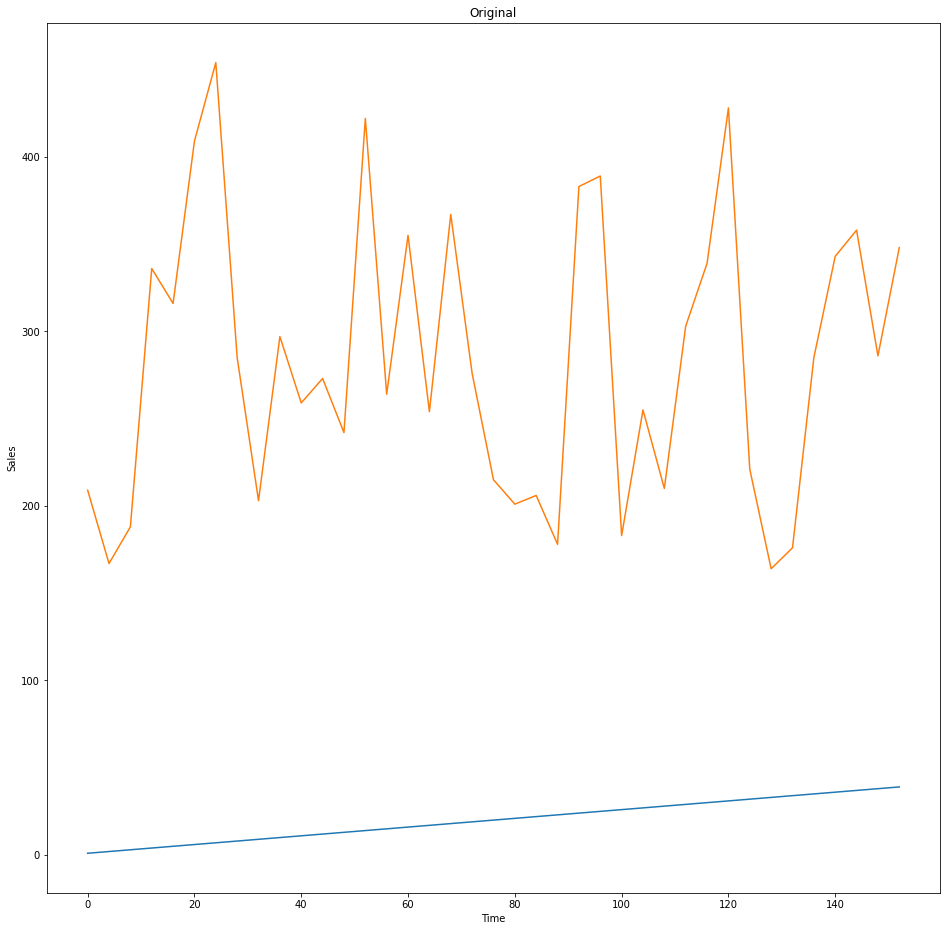

In [1004]:
import matplotlib.pyplot as plt
# ts=df.groupby(["block_num", "shopId"])["sales"].sum()
# ts = ts.astype('float')
plt.figure(figsize=(16,16))
# plt.subplot(311) 
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

In [1060]:
df['sales'] = df["sales"].astype(float)
ts=df.groupby(["block_num", "shopId"])["sales"].sum()
ts = ts.reset_index()
ts = ts[ts.shopId == 170].drop('shopId', axis=1)
ts=ts[:-2]
print(ts.shape)
# ts.astype('float')
# ts = ts.reset_index()
ts.columns=['ds','y']
x = pd.date_range(start='2017-01-01', end='2020-01-01', freq='MS')
print(x.shape)
ts['ds'] = x

(37, 2)
(37,)


In [1061]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      37 non-null     datetime64[ns]
 1   y       37 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 888.0 bytes


In [1062]:
ts

,ds,y
0,2017-01-01,209.0
4,2017-02-01,167.0
8,2017-03-01,188.0
12,2017-04-01,336.0
16,2017-05-01,316.0
20,2017-06-01,409.0
24,2017-07-01,454.0
28,2017-08-01,285.0
32,2017-09-01,203.0
36,2017-10-01,297.0


https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts


In [1063]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [1064]:
future = model.make_future_dataframe(periods = 2, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2019-11-01,236.940335,174.049174,301.995631
35,2019-12-01,338.021779,269.863184,406.226823
36,2020-01-01,366.731235,297.835737,434.962860
37,2020-02-01,198.104515,137.657692,266.580643
38,2020-03-01,191.260060,125.202593,256.401159


In [1072]:
df['sales'] = df["sales"].astype(float)
ts=df.groupby(["block_num", "shopId"])["sales"].sum()
ts = ts.reset_index()
ts = ts[ts.shopId == 170].drop('shopId', axis=1)
ts.columns=['ds','y']
x = pd.date_range(start='2017-01-01', end='2020-03-01', freq='MS')
print(x.shape)
ts['ds'] = x
ts[-2:]

(39,)


,ds,y
148,2020-02-01,286.0
152,2020-03-01,348.0


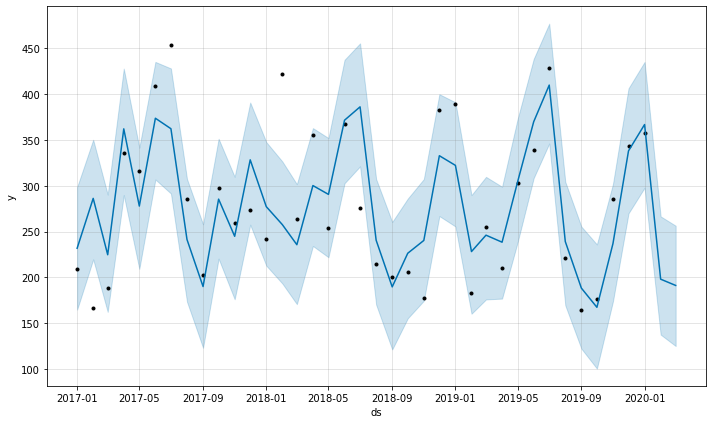

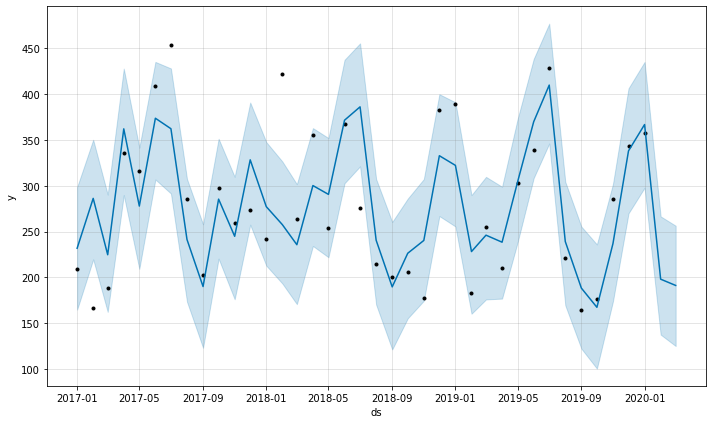

In [1065]:
model.plot(forecast)

агрегируем по месяцам без промо

In [1012]:
df.head()

,block_num,shopId,sales_month,std_price,avg_price,num_of_promo_days_month,percentage_price_change,sales,price,promo_num_month
0,1,170,209,3.701897,42.229221,0.0,0.0,1,38.7,0
1,1,170,209,3.701897,42.229221,0.0,0.0,1,38.7,0
2,1,170,209,3.701897,42.229221,0.0,0.0,2,38.7,0
3,1,170,209,3.701897,42.229221,0.0,0.0,1,38.7,0
4,1,170,209,3.701897,42.229221,0.0,0.0,1,38.7,0


In [1053]:
df[df.promoId.isna()].shape

(39816, 14)

In [1054]:
ts=df[df.promoId.isna()].groupby(["block_num", "shopId"])["sales"].sum()
ts = ts.reset_index()
ts = ts[ts.shopId == 170].drop('shopId', axis=1)
ts=ts[:-2]
print(ts.shape)
# ts.astype('float')
# ts = ts.reset_index()
ts.columns=['ds','y']
x = pd.date_range(start='2017-01-01', end='2020-01-01', freq='MS')
print(x.shape)
ts['ds'] = x

(37, 2)
(37,)


In [1055]:
future = model.make_future_dataframe(periods = 2, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2019-11-01,236.940335,171.003864,306.133287
35,2019-12-01,338.021779,273.997909,406.045077
36,2020-01-01,366.731235,304.149899,431.732240
37,2020-02-01,198.104515,135.863739,263.771406
38,2020-03-01,191.260060,123.942183,258.480416


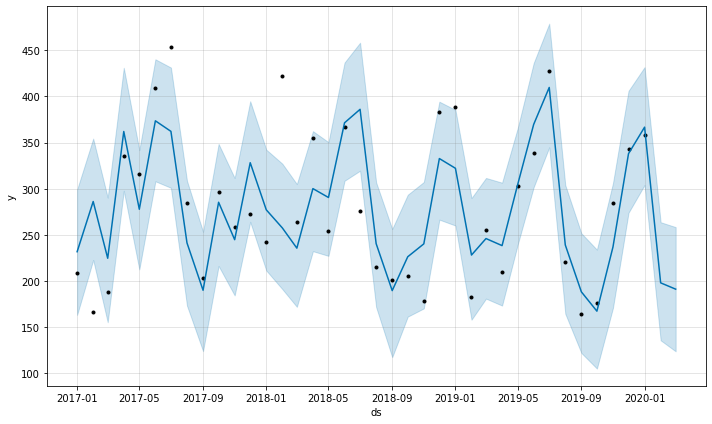

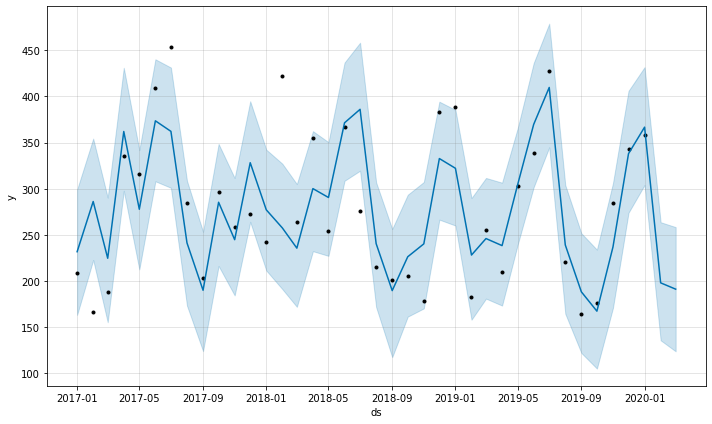

In [1056]:
model.plot(forecast)

In [1073]:
df['sales'] = df["sales"].astype(float)
ts=df[df.promoId.isna()].groupby(["block_num", "shopId"])["sales"].sum()
ts = ts.reset_index()
ts = ts[ts.shopId == 170].drop('shopId', axis=1)
ts.columns=['ds','y']
x = pd.date_range(start='2017-01-01', end='2020-03-01', freq='MS')
print(x.shape)
ts['ds'] = x
ts[-2:]

(39,)


,ds,y
148,2020-02-01,138.0
152,2020-03-01,232.0


# Обучаем xgboost regressor на 1 товаре и 4х магазинах за 4 года с промо

https://www.kaggle.com/dlarionov/feature-engineering-xgboost#Part-2,-xgboost

In [1496]:
ts = df.groupby(['block_num', 'shopId'])[['num_of_promo_days_month', 'percentage_price_change', 'promo_num_month', 'price']].max()
ts = ts.join(df.groupby(['block_num', 'shopId'])['price'].mean().to_frame().rename(columns={'price':'price_avg'}))
ts = ts.join(df.groupby(['block_num', 'shopId'])['price'].std().to_frame().rename(columns={'price':'price_std'}))
ts = ts.join(df.groupby(['block_num', 'shopId'])['sales'].sum())
ts = ts.reset_index()

In [1497]:
ts_lagged = ts[ts.block_num > 2]
ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 1
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'sales']].rename(columns={'sales':'sales_lag1'}), on=['block_num', 'shopId'])

ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 2
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'sales']].rename(columns={'sales':'sales_lag2'}), on=['block_num', 'shopId'])

In [1498]:
# ts_lagged = ts[ts.block_num > 2]
ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 1
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'num_of_promo_days_month']].rename(columns={'num_of_promo_days_month':'num_of_promo_days_month_lag1'}), on=['block_num', 'shopId'])

ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 2
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'num_of_promo_days_month']].rename(columns={'num_of_promo_days_month':'num_of_promo_days_month_lag2'}), on=['block_num', 'shopId'])

In [1499]:
from xgboost import XGBRegressor

In [1500]:
Y_pred_promo, Y_test_promo = [], []
data = ts_lagged
for i in range(0, 2):

    X_train = data[data.block_num < 38 - i].drop(['sales'], axis=1)
    Y_train = data[data.block_num < 38 - i]['sales']
    X_valid = data[data.block_num == 38 - i].drop(['sales'], axis=1)
    Y_valid = data[data.block_num == 38 - i]['sales']
    X_test = data[data.block_num == 39 - i].drop(['sales'], axis=1)

    model = XGBRegressor(
        max_depth=2,
        n_estimators=10,
        min_child_weight=5, 
        colsample_bytree=0.1, 
        subsample=0.9, 
        eta=0.05,    
        seed=42)

    model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True)

    Y_pred_promo.append(model.predict(X_valid))
    Y_test_promo.append(model.predict(X_test))

[0]	validation_0-rmse:556.40100	validation_1-rmse:344.26550
[1]	validation_0-rmse:537.23517	validation_1-rmse:322.58536
[2]	validation_0-rmse:516.93433	validation_1-rmse:292.58896
[3]	validation_0-rmse:499.98676	validation_1-rmse:271.64600
[4]	validation_0-rmse:485.04895	validation_1-rmse:252.87398
[5]	validation_0-rmse:470.95932	validation_1-rmse:234.86137
[6]	validation_0-rmse:457.33505	validation_1-rmse:218.05554
[7]	validation_0-rmse:443.96753	validation_1-rmse:201.70880
[8]	validation_0-rmse:432.22543	validation_1-rmse:186.06026
[9]	validation_0-rmse:421.51547	validation_1-rmse:170.87791
[0]	validation_0-rmse:559.87396	validation_1-rmse:418.72668
[1]	validation_0-rmse:540.72461	validation_1-rmse:399.87421
[2]	validation_0-rmse:523.18188	validation_1-rmse:386.70142
[3]	validation_0-rmse:503.94775	validation_1-rmse:359.15454
[4]	validation_0-rmse:487.55881	validation_1-rmse:339.19244
[5]	validation_0-rmse:469.46393	validation_1-rmse:319.84387
[6]	validation_0-rmse:455.92310	validati

# Обучаем xgboost regressor на 1 товаре и 4х магазинах за 4 года без промо

In [1501]:
df_no_promo = df[df.promoId.isna()]
ts = df_no_promo.groupby(['block_num', 'shopId'])[['price']].max()
ts = ts.join(df.groupby(['block_num', 'shopId'])['sales'].sum())
ts = ts.reset_index()

In [1502]:
ts_lagged = ts[ts.block_num > 2]
ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 1
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'sales']].rename(columns={'sales':'sales_lag1'}), on=['block_num', 'shopId'])

ts_help = ts.copy()
ts_help['block_num'] = ts_help['block_num'] + 2
ts_lagged = ts_lagged.merge(ts_help[['block_num', 'shopId', 'sales']].rename(columns={'sales':'sales_lag2'}), on=['block_num', 'shopId'])

In [1503]:
Y_pred_no_promo, Y_test_no_promo = [], []
data = ts_lagged
for i in range(0, 2):

    X_train = data[data.block_num < 38 - i].drop(['sales'], axis=1)
    Y_train = data[data.block_num < 38 - i]['sales']
    X_valid = data[data.block_num == 38 - i].drop(['sales'], axis=1)
    Y_valid = data[data.block_num == 38 - i]['sales']
    X_test = data[data.block_num == 39 - i].drop(['sales'], axis=1)

    model = XGBRegressor(
        max_depth=2,
        n_estimators=10,
        min_child_weight=5, 
        colsample_bytree=0.1, 
        subsample=0.9, 
        eta=0.05,    
        seed=42)

    model.fit(
        X_train, 
        Y_train, 
        eval_metric="rmse", 
        eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
        verbose=True, 
        early_stopping_rounds = 10)

    Y_pred_no_promo.append(model.predict(X_valid))
    Y_test_no_promo.append(model.predict(X_test))

[0]	validation_0-rmse:556.93530	validation_1-rmse:347.75916
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:538.12122	validation_1-rmse:328.23526
[2]	validation_0-rmse:517.66962	validation_1-rmse:298.97174
[3]	validation_0-rmse:500.56244	validation_1-rmse:279.04471
[4]	validation_0-rmse:485.35394	validation_1-rmse:263.75082
[5]	validation_0-rmse:469.11008	validation_1-rmse:239.47014
[6]	validation_0-rmse:455.43915	validation_1-rmse:221.61832
[7]	validation_0-rmse:442.64450	validation_1-rmse:204.62294
[8]	validation_0-rmse:427.18054	validation_1-rmse:187.55850
[9]	validation_0-rmse:415.81094	validation_1-rmse:175.47156
[0]	validation_0-rmse:560.42602	validation_1-rmse:421.96256
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:

stat test

In [1504]:
import numpy as np
Y_test_no_promo = np.hstack(Y_test_no_promo)

In [1505]:
Y_test_promo = np.hstack(Y_test_promo)

In [1506]:
Y_test_promo - Y_test_no_promo

array([ 28.32048  ,  22.39029  , -41.871887 ,  -4.9537354,  24.11763  ,
        12.397003 ,  -8.865433 , -40.85962  ], dtype=float32)

In [1507]:
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
import scipy
import statsmodels

In [1508]:
print("sgd model mean auc 95%% confidence interval", _tconfint_generic(Y_test_promo.mean(), Y_test_promo.std(),
                                                                       len(Y_test_promo) - 1,
                                                                       0.05, 'two-sided'))

print("ridge model mean auc 95%% confidence interval", _tconfint_generic(Y_test_no_promo.mean(), Y_test_no_promo.std(),
                                                                         len(Y_test_no_promo) - 1,
                                                                         0.05, 'two-sided'))

sgd model mean auc 95%% confidence interval (140.69269140786886, 214.3952602522874)
ridge model mean auc 95%% confidence interval (108.66729152318555, 248.75202000025195)


In [1509]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


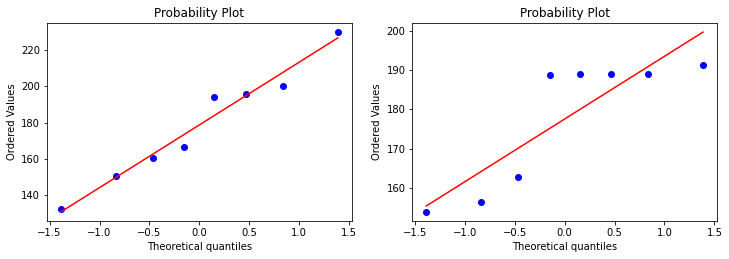

In [1510]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(Y_test_no_promo, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(Y_test_promo, dist="norm", plot=pylab)
pylab.show()

In [1511]:
scipy.stats.ttest_ind(Y_test_no_promo, Y_test_promo, equal_var = False)

Ttest_indResult(statistic=0.09214384502344054, pvalue=0.9283021339813903)

In [1512]:
stats.ttest_rel(Y_test_no_promo, Y_test_promo)

Ttest_relResult(statistic=0.1170502610467248, pvalue=0.9101078126406995)

# Делю временной ряд по неделям вместо месяцов, как в предыдущих клетках

In [1541]:
display(df.head()) 
display(df.tail())

,shopId,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,priceAkcia,typePromo,statusPromo,count_skuId,count_promo
0,174,47336,"0,39","37,01",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,174,101235,"0,745","63,25",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,172,25880,"0,925","92,41",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
3,172,4715,3,"109,5",10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,172,4342,"1,5",78,10.01.2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


,shopId,skuId,sales,salesRub,date,promoId,startDate,finishDate,price,discont,priceAkcia,typePromo,statusPromo,count_skuId,count_promo
1048570,173,172387,"1,5","86,85",21.04.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1048571,173,4342,"1,5","73,5",21.04.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1048572,173,4342,"1,5","73,5",21.04.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1048573,170,151207,1,"65,5",21.04.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1048574,172,75711,4,"55,2",21.04.2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [1542]:
df.shape

(1048575, 15)

In [ ]:
df2 = df.groupby(pd.Grouper(freq='W', key='Dates'))['Nums'].agg(['max','last'])